In [1]:
import keras
import numpy as np
import sklearn
from keras import backend as K
import os
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline  
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [25,5]

Using TensorFlow backend.


In [10]:
train_blur_dirs = [('datav7/train30000/median','median'),
                   ('datav7/train30000/gaussian','gaussian'),
                   ('datav7/train30000/down','down')]
train_ori_dir = 'datav7/train30000/ori'

dev_blur_dirs = [('datav7/dev20000/median','median'),
                 ('datav7/dev20000/gaussian','gaussian'),
                 ('datav7/dev20000/down','down')]
dev_ori_dir = 'datav7/dev20000/ori'

test_blur_dirs = [('datav7/test20000/median','median'),
                 ('datav7/test20000/gaussian','gaussian'),
                 ('datav7/test20000/down','down')]
test_ori_dir = 'datav7/test20000/ori'

In [11]:
X_train = []
y_train = []
train_size = 30000 # for images in each folder

for (train_blur_dir,prefix) in train_blur_dirs:
    for i in range(train_size):
        X_train.append(os.path.join(train_blur_dir, '{}{}.png'.format(prefix,i)))
        y_train.append(os.path.join(train_ori_dir, '{}{}.png'.format('ori',i)))

In [12]:
X_dev = []
y_dev = []
dev_size = 20000 # for images in each folder

for (dev_blur_dir,prefix) in dev_blur_dirs:
    for i in range(dev_size):
        X_dev.append(os.path.join(dev_blur_dir, '{}{}.png'.format(prefix,i)))
        y_dev.append(os.path.join(dev_ori_dir, '{}{}.png'.format('ori',i)))

In [13]:
X_test = []
y_test = []
test_size = 20000 # for images in each folder

for (test_blur_dir,prefix) in test_blur_dirs:
    for i in range(test_size):
        X_test.append(os.path.join(test_blur_dir, '{}{}.png'.format(prefix,i)))
        y_test.append(os.path.join(test_ori_dir, '{}{}.png'.format('ori',i)))

In [14]:
from skimage.io import imread
from skimage.transform import resize
from skimage import color
from keras.utils import Sequence

class generator(Sequence):
    def __init__(self, x_set, y_set, batch_size=32):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

#         return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.
        
        X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
        y = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_y])
        return X.reshape(-1,50,300,1), y.reshape(-1,50,300,1)
    
    
class pred_generator(Sequence):
    def __init__(self, x_set, batch_size=32):
        self.x = x_set          
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

#         return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.
        X = np.array([color.rgb2gray(imread(file_name)) for file_name in batch_x])
        return X.reshape(-1,50,300,1)

In [16]:
def psnr(y_true, y_pred):    
    return tf.image.psnr(y_true, y_pred, max_val=1)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))*255.

In [17]:
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, Flatten, Dense, Reshape, Add
from keras.models import Model

def get_model(input_shape): 
  #input 1-image (inverse)
    x = Input(shape = input_shape)
    c1 = Conv2D(64, 9, strides=1, activation = 'relu', padding='same')(x)
    c2 = Conv2D(32, 1, strides=1, activation = 'relu', padding='same')(c1)
    c3 = Conv2D(input_shape[2], 5, strides=1, activation = 'relu', padding='same')(c2)
    model = Model(inputs = x, outputs = c3)
    return model


def get_model2(input_shape): 
    #input image
    x = Input(shape = input_shape)

    c1 = Conv2D(64, 9, strides=1, padding='same')(x)
    b1 = BatchNormalization()(c1)
    h1 = Activation('relu')(b1)

    c2 = Conv2D(32, 3, strides=1, activation = 'relu', padding='same')(h1)
    #   b2 = BatchNormalization()(c2)
    h2 = Activation('relu')(c2)

    c3 = Conv2D(10, 5, strides=1, activation = 'relu', padding='same')(h2)
    #   b3 = BatchNormalization()(c3)
    h3 = Activation('relu')(c3)

    c4 = Conv2D(input_shape[2], 5, strides=1, padding='same')(h3)
    h4 = Activation('relu')(c4)

    model = Model(inputs = x, outputs = h4)

    return model

def get_model3(input_shape): 
    #input image
    x = Input(shape = input_shape)

    c1 = Conv2D(64, 3, strides=1, padding='same')(x)
    b1 = BatchNormalization()(c1)
    h1 = Activation('relu')(b1)

    c2 = Conv2D(64, 3, strides=1, activation = 'relu', padding='same')(h1)
    h2 = Activation('relu')(c2)

    c3 = Conv2D(64, 3, strides=1, activation = 'relu', padding='same')(h2)
    h3 = Activation('relu')(c3)
    
    c4 = Conv2DTranspose(64, 3, strides=1, activation = 'relu', padding='same')(h3)
    m4 = Add()([c3, c4])
    h4 = Activation('relu')(m4)
    
    c5 = Conv2DTranspose(64, 3, strides=1, activation = 'relu', padding='same')(h4)
    m5 = Add()([c2, c5])
    h5 = Activation('relu')(m5)
    
    c6 = Conv2DTranspose(64, 3, strides=1, activation = 'relu', padding='same')(h5)
    m6 = Add()([c1, c6])
    h6 = Activation('relu')(m6)
    
    c7 = Conv2DTranspose(1, 3, strides=1, activation = 'relu', padding='same')(h6)
    h7 = Activation('relu')(c7)
    
    model = Model(inputs = x, outputs = c7)

    return model

def get_model4(input_shape): 
  #input 1-image (inverse)
    x = Input(shape = input_shape)
    model = Model(inputs = x, outputs = x)
    return model

# train model 3

In [26]:
K.clear_session()
model3 = get_model3(input_shape=(50,300,1))
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 300, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 300, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 300, 64)  256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 50, 300, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [27]:
from keras.optimizers import Adam
model3.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'model_weight/model3_datav7/model_weight.hdf5'
csv_log_path = 'training_log/model3_datav7/training.log'
tensor_log_path = 'tensor_board_log/model3_datav7'

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0005),
    EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=tensor_log_path, write_graph=True, write_grads=False, batch_size=128),
    CSVLogger(csv_log_path)
]
model3.fit_generator(generator(X_train,y_train,batch_size=128),
                    validation_data=generator(X_dev,y_dev, batch_size=128),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

NameError: name 'saved_path' is not defined

# train model 3 (rgb)

In [ ]:
class generator_rgb(Sequence):
    def __init__(self, x_set, y_set, batch_size=32):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.

In [ ]:
class pred_generator_rgb(Sequence):
    def __init__(self, x_set, batch_size=32):
        self.x = x_set          
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([imread(file_name) for file_name in batch_x])/255., np.array([imread(file_name) for file_name in batch_y])/255.

In [ ]:
K.clear_session()
model3 = get_model3(input_shape=(50,300,3))
model3.summary()

In [ ]:
from keras.optimizers import Adam
model3.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'model_weight/model3_datav7_rgb/model_weight.hdf5'
csv_log_path = 'training_log/model3_datav7_rgb/training.log'
tensor_log_path = 'tensor_board_log/model3_datav7_rgb'

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0005),
    EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=tensor_log_path, write_graph=True, write_grads=False, batch_size=128),
    CSVLogger(csv_log_path)
]
model3.fit_generator(generator_rgb(X_train,y_train,batch_size=128),
                    validation_data=generator_rgb(X_dev,y_dev, batch_size=128),
                    epochs=20, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

# train model 2

In [ ]:
K.clear_session()
model = get_model2(input_shape=(40,600,3))
model.load_weights('model_weight/SRCNN/model_weight.hdf5')
model.summary()

In [ ]:
from keras.optimizers import Adam
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

saved_path = 'model_weight/SRCNN_v2/model_weight.hdf5'
csv_log_path = 'training_log/SRCNN_v2/training.log'
tensor_log_path = 'tensor_board_log/SRCNN_v2'

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard, CSVLogger
callbacks = [
    ModelCheckpoint(saved_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0005),
    EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=False),
    TensorBoard(log_dir=tensor_log_path, write_graph=True, write_grads=False, batch_size=128),
    CSVLogger(csv_log_path)
]
model.fit_generator(generator(X_train,y_train,batch_size=32),
                    validation_data=generator(X_dev,y_dev, batch_size=32),
                    epochs=10, verbose=1, callbacks=callbacks, 
                    validation_steps=None, 
                    use_multiprocessing=False, shuffle=True)

# model4

In [ ]:
K.clear_session()
model4 = get_model4(input_shape=(40,600,3))
model4.compile(Adam(), loss='mse', metrics=[psnr, mae])
model4.summary()

In [ ]:
model4.evaluate_generator(generator(X_dev,y_dev,batch_size=64), verbose=1)

# test

In [ ]:
# model2 = get_model2(input_shape=(100,600,3))
# model3 = get_model3(input_shape=(100,600,3))

In [ ]:
# model2.load_weights('model_weight/model2/model_weight.hdf5')
model3.load_weights('model_weight/modified_model3/model_weight.hdf5')

In [ ]:
generator = generator(X_dev,y_dev,batch_size=32)

In [ ]:
test_ori = imread('datav6/dev20000/ori/ori15.png')
test_median = imread('datav6/dev20000/median/median15.png')
test_gaussian = imread('datav6/dev20000/gaussian/gaussian15.png')
test_down = imread('datav6/dev20000/down/down15.png')

In [ ]:
# model2.predict(test_median[np.newaxis,:,:,:])
# # model2.predict(test_gaussian[np.newaxis,:,:,:])
# # model2.predict(test_down[np.newaxis,:,:,:])

In [ ]:
fig, axes = plt.subplots(4, 1,  figsize=(10,5))
axes[0].imshow(test_ori)
axes[1].imshow(test_median)
axes[2].imshow(test_ori-test_median)
# axes[2].imshow(model3.predict(test_median[np.newaxis,:,:,:]/255.0)[0])    
axes[3].imshow(model3.predict(test_median - test_median[np.newaxis,:,:,:]/255.0)[0])
# axes[1,2].imshow(target[i].reshape(30,200), cmap='gray')

In [ ]:
_mae(resize(test_ori,(40,400,3),anti_aliasing=False),resize(test_median,(40,400,3),anti_aliasing=False))

In [ ]:
fig, axes = plt.subplots(3, 1,  figsize=(25,10))
axes[0].imshow(test_ori)
axes[1].imshow(test_gaussian)
axes[2].imshow(model.predict(test_gaussian[np.newaxis,:,:,:]/255.0).reshape(40,600,3))   

In [ ]:
fig, axes = plt.subplots(4, 1,  figsize=(15,8))
axes[0].imshow(test_ori)
axes[1].imshow(test_down)
axes[2].imshow(test_ori - test_down)
axes[3].imshow(model3.predict(test_down[np.newaxis,:,:,:]/255.0)[0]*255 - test_down)

In [ ]:
test_down-model.predict(test_down[np.newaxis,:,:,:]/255.0)[0]

# test baseline

In [ ]:
def _mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float"))**2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def _mae(imageA, imageB):
    err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def _psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
sum_mae = 0
sum_mse = 0
sum_psnr = 0
for i in tqdm(range(25000)):
    ori_img = imread(y_dev[i])
    blur_img = imread(X_dev[i])
    sum_mae += mae(ori_img,blur_img)
    sum_mse += mse(ori_img,blur_img)
    sum_psnr += psnr(ori_img,blur_img)
print('baseline_mae:',sum_mae/25000)
print('baseline_mse:',sum_mse/25000)
print('baseline_psnr:',sum_psnr/25000)

In [ ]:
# model3.evaluate_generator(generator(X_dev[:5000],y_dev[:5000],batch_size=64), verbose=1)

In [ ]:
model4 = get_model4((50,300,1))
model4.compile(Adam(), loss='mse', metrics=[psnr, mae])
model4.evaluate_generator(generator(X_train,y_train,batch_size=128), verbose=1)

In [ ]:
model4.evaluate_generator(generator(X_train[60000:],y_train[60000:],batch_size=128), verbose=1)

# comparing images

In [ ]:
!pwd

In [52]:
# test_path = 'drive/My Drive/computer_vision/testing2'
def comparing(model, X, y, batch_size=10):
  
  for b, (source, target) in enumerate(generator(X, y, batch_size=batch_size)):
    
    results = model.predict(source)
    
    fig, axes = plt.subplots(len(results), 3,  figsize=(100,5*len(results)))
    
    for i, result in enumerate(results):                

#       axes[i,0].imshow(source[i], cmap='gray')
#       axes[i,1].imshow(result, cmap='gray')
#       axes[i,2].imshow(target[i], cmap='gray')
      axes[i,0].imshow(np.reshape(source[i], (50,300)), cmap='gray')
      axes[i,1].imshow(np.reshape(result, (50,300)), cmap='gray')
      axes[i,2].imshow(np.reshape(target[i], (50,300)), cmap='gray')
#     print(i, len(results))
#     fig.savefig(os.path.join(test_path,'test_{}-{}.png'.format(b*batch_size, b*batch_size+len(results))))
      fig.show()
    plt.show()

In [ ]:
comparing(model4, X_dev[1000:1010], y_dev[1000:1010])

# eval model 3

In [22]:
model = get_model3(input_shape=(50,300,1))
model.compile(Adam(), loss='mse', metrics=[psnr, mae])

In [23]:
model.load_weights('model_weight/model3_datav7/model_weight.hdf5')

In [25]:
model.evaluate_generator(generator(X_test,y_test,batch_size=128), verbose=1)

469/469 [==============================] - 848s 2s/step


[0.001547381980655094, 29.72811017252604, 3.0961334665934244]

In [26]:
model.evaluate_generator(generator(X_test[0:20000],y_test[0:20000],batch_size=128), verbose=1)

157/157 [==============================] - 73s 465ms/step


[0.0017467348117381335, 30.448321557617188, 2.4513429317474364]

In [27]:
model.evaluate_generator(generator(X_test[20000:40000],y_test[20000:40000],batch_size=128), verbose=1)

157/157 [==============================] - 73s 464ms/step


[0.0011208930181339383, 30.55967485961914, 3.3243650550842285]

In [28]:
model.evaluate_generator(generator(X_test[40000:],y_test[40000:],batch_size=128), verbose=1)

157/157 [==============================] - 73s 463ms/step


[0.0017745181128382683, 28.176334020996094, 3.512692413711548]

In [29]:
def convert_mse(val):
    return ((val**0.5)*255)**2

In [50]:
convert_mse(0.0017467348117381335)

113.58143113327212

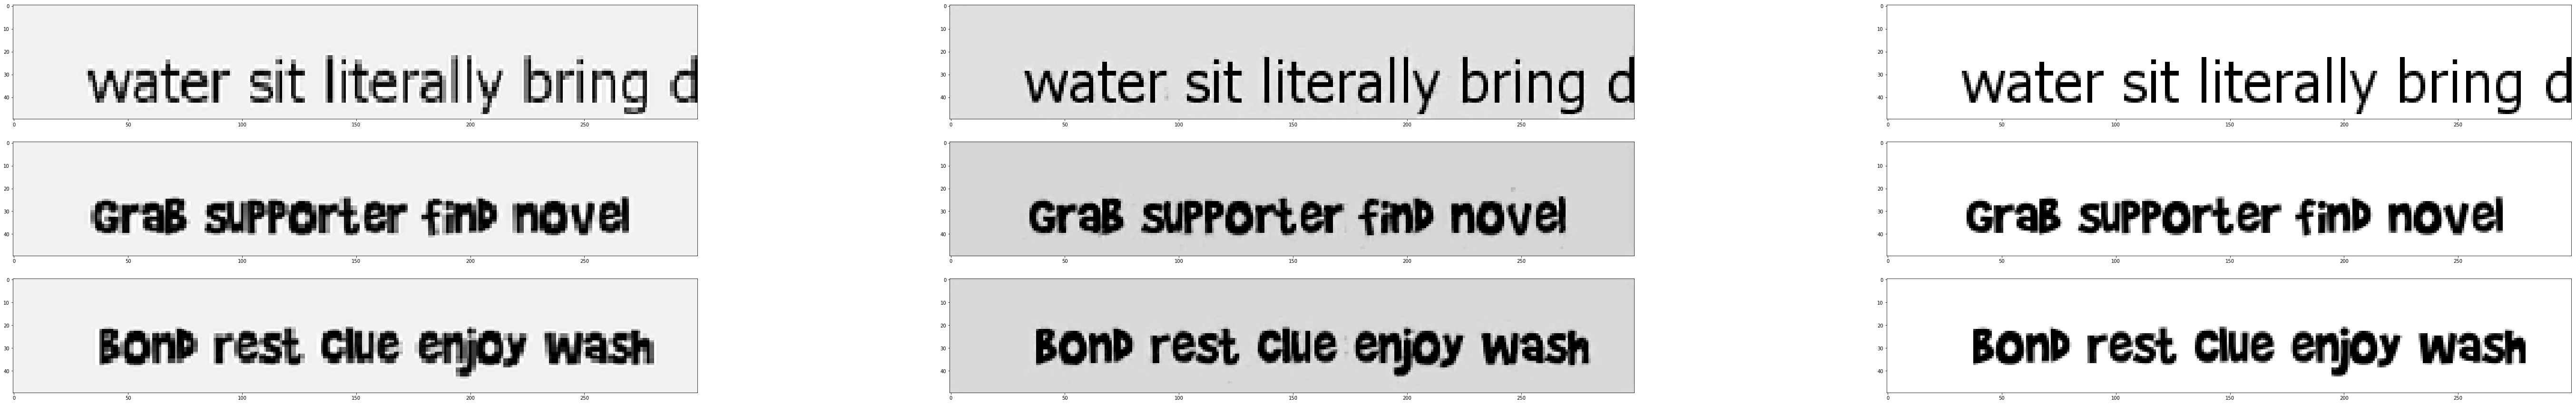

In [62]:
comparing(model, X_dev[43000:43003], y_dev[43000:43003])